In [85]:
import pandas as pd

# read synthetic data
data = pd.read_csv('datasets/real_life_regressor.csv')
data.head()

,h_1,h_2,x_1,x_2,x_3,y
0,-0.507907,-0.426783,-0.348796,-0.156770,-0.197266,0
1,0.208406,0.579240,-0.049915,-0.135873,-0.057563,1
2,-0.408581,0.486722,-0.734377,-0.359439,-0.515557,1
3,-0.686362,0.810403,-0.127156,0.049691,-0.722663,1
4,-0.270678,0.418167,-0.747838,-0.360587,-0.447434,1


In [86]:
from sklearn.decomposition import FactorAnalysis

# use FA to extract features from the variables
latent = FactorAnalysis(n_components=2, random_state=0).fit_transform(data[['x_1', 'x_2', 'x_3']])

# convert np array into a dataframe
latent = pd.DataFrame(latent, columns=['z_1', 'z_2'])

# add latent variables to data
data = pd.concat([data, latent], axis=1)

data.head()

,h_1,h_2,x_1,x_2,x_3,y,z_1,z_2
0,-0.507907,-0.426783,-0.348796,-0.156770,-0.197266,0,-0.776260,-0.073642
1,0.208406,0.579240,-0.049915,-0.135873,-0.057563,1,-0.290319,-0.316002
2,-0.408581,0.486722,-0.734377,-0.359439,-0.515557,1,-1.652753,-0.252512
3,-0.686362,0.810403,-0.127156,0.049691,-0.722663,1,-0.580926,2.278651
4,-0.270678,0.418167,-0.747838,-0.360587,-0.447434,1,-1.633168,-0.433425


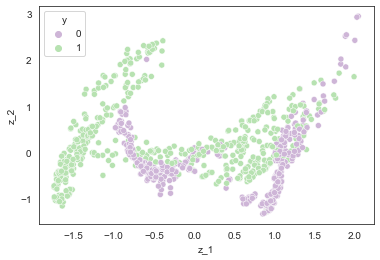

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the data for latent variables
sns.set_style('white')
sns.set_palette('PRGn', 2)
sns.scatterplot(data=data, x='z_1', y='z_2', hue='y')
plt.savefig('figures/factor_analysis_synthetic.png', dpi=200)
plt.show()

In [88]:
# check the correlation matrix
data[['h_1', 'h_2', 'z_1', 'z_2']].corr()

,h_1,h_2,z_1,z_2
h_1,1.000000,0.032786,8.788854e-01,-1.199534e-01
h_2,0.032786,1.000000,-2.496867e-01,4.679032e-01
z_1,0.878885,-0.249687,1.000000e+00,8.854165e-13
z_2,-0.119953,0.467903,8.854165e-13,1.000000e+00


In [89]:
import numpy as np

# define a function to calculate the multiple correlation
def multiple_correlation(df, y_name, z_list):
    c = df[[y_name] + z_list].corr()['y'].iloc[1:].to_numpy()
    R = df[[y_name] + z_list].corr().loc[z_list, z_list].to_numpy()
    return c.T @ np.linalg.inv(R) @ c

print(f"h: {multiple_correlation(data, 'y', ['h_1', 'h_2']):.2f}, "
      f"x: {multiple_correlation(data, 'y', ['x_1', 'x_2', 'x_3']):.2f}, "
      f"z: {multiple_correlation(data, 'y', ['z_1', 'z_2']):.2f}")

h: 0.89, x: 0.35, z: 0.18


In [92]:
from tqdm.notebook import tqdm

# define the distance that will be used for the kruskal's stress
def distance(a, b):
    return np.linalg.norm(a - b)

# define the stress function
def stress_function(x, z, scale_factor):
    top_sum, bottom_sum = 0, 0
    for i in range(x.shape[0]):
        for j in range(i):
            top_sum += (distance(x[i], x[j]) - scale_factor * distance(z[i], z[j])) ** 2
            bottom_sum += distance(x[i], x[j]) ** 2
    return np.sqrt(top_sum / bottom_sum)

# find the inverted kruskal's stress by searching different lambdas
def inverted_kruskals_stress(df, x_list, z_list, accuracy):
    x, z = df[x_list].to_numpy(), df[z_list].to_numpy()
    lower_bound, upper_bound, window_size = 0.2, 5, 4.8

    while window_size > accuracy:
        print(f'Search Range: [{lower_bound:.5f}, {upper_bound:.5f}]')
        search_range, stress_list = np.linspace(lower_bound, upper_bound, 10), []
        for scale in tqdm(search_range):
            stress_list.append(stress_function(x, z, scale))

        argmin = np.argmin(stress_list)

        if argmin == 0:
            lower_bound = max(0, lower_bound - window_size)
            upper_bound = search_range[1]
        elif argmin == 9:
            lower_bound = search_range[8]
            upper_bound = upper_bound + window_size
        else:
            lower_bound = search_range[argmin - 1]
            upper_bound = search_range[argmin + 1]

        window_size = upper_bound - lower_bound
        print(f'Inverted Stress: {1 - stress_list[argmin]:.3f}, New Window Size: {window_size:.5f}')

    return 1 - stress_function(x, z, 0.5 * (upper_bound + lower_bound))

inverted_kruskals_stress(data, ['x_1', 'x_2', 'x_3'], ['z_1', 'z_2'], 0.001)

Search Range: [0.20000, 5.00000]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.506, New Window Size: 1.06667
Search Range: [0.20000, 1.26667]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.740, New Window Size: 0.23704
Search Range: [0.43704, 0.67407]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.755, New Window Size: 0.05267
Search Range: [0.48971, 0.54239]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.756, New Window Size: 0.01171
Search Range: [0.50142, 0.51312]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.756, New Window Size: 0.00260
Search Range: [0.50662, 0.50922]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.756, New Window Size: 0.00058


0.7557300701286831

In [107]:
from sklearn.feature_selection import mutual_info_regression

def individual_mig(df, h_k, z_list):
    mutual_information = mutual_info_regression(df[z_list], df[h_k])
    first = np.max(mutual_information)
    second = np.max(mutual_information[mutual_information != first])
    return first - second

def mutual_information_gap(df, h_list, z_list):
    mig = [individual_mig(df, h_k, z_list) for h_k in h_list]
    return np.mean(mig)

mutual_information_gap(data, ['h_1', 'h_2'], ['z_1', 'z_2'])

0.4991650162897374